### **Caso de Estudio: Predicción del Precio del Oro con Redes LSTM**  
**Duración:** 1 semana  


---

## **1. Business Case Discovery**  
### **1.1 Contexto del Negocio**  
La empresa **Commodity Analytics** busca optimizar estrategias de inversión en metales preciosos. **El oro se ve afectado por factores macroeconómicos complejos (inflación, tasas de interés, crisis geopolíticas)** que dificultan el análisis manual. El objetivo es desarrollar un modelo predictivo que analice datos históricos **del precio del oro (XAU/USD) y variables macroeconómicas** para predecir su valor futuro.

 
### **1.2 Objetivo del Proyecto**  
Construir una LSTM que prediga el precio de cierre del oro para los próximos **5 días hábiles**, usando:
- **Datos históricos diarios** (2010-2024)
- **Indicadores macro:** Índice Dólar (DXY), tasas de interés FED, inflación , etc
- **Métrica de éxito:** RMSE < 10% 

---

## **2. Data Processing**  
### **2.1 Fuentes de Datos**  
- **Precio oro:** Yahoo Finance (`GC=F`) 
- **Datos macro:** Yahoo Finance 

In [1]:
# Importar las librerías necesarias
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler, RobustScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# 1. Precio del oro (futuros)
df_oro = yf.download("GC=F", start="2010-01-01")

# 2. Índice Dólar (DXY)
df_dxy = yf.download("DX-Y.NYB", start="2010-01-01")  # Ticker correcto para DXY

# 3. Bonos 10 años (^TNX como proxy de tasas de interés)
df_bonos = yf.download("^TNX", start="2010-01-01")

# 4. Inflación (usar ETF TIP como proxy)
df_inflacion = yf.download("TIP", start="2010-01-01")  # ETF de bonos indexados a inflación

2025-04-28 11:22:53.057061: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-28 11:22:54.412506: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745832174.886678   33695 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745832175.003699   33695 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1745832176.183512   33695 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

[*********************100%***********************]  1 of 1 completed

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


### **2.2 Ingeniería de Características**  
**Variables clave para el oro:**
1. **Ratio Oro/Dólar:** Precio oro ajustado por fuerza del USD (`Precio Oro / DXY`), Para evitar data leakage, se calcula la razón utilizando los valores del día anterior. De esta forma, para predecir el precio en el día t la característica se basa en datos hasta t–1 y no "mira hacia el futuro".
2. **Inflación implícita:** Variación porcentual mensual del ETF TIP (proxy para CPI)
3. **Tasa real aproximada** Rendimiento bonos 10 años (^TNX) - Inflación implícita  

In [2]:
# Extraer los precios de cierre
oro = df_oro['Close']
dxy = df_dxy['Close']
bonos = df_bonos['Close']
tip = df_inflacion['Close']

# Crear DataFrame principal
df = pd.concat([oro, dxy, bonos, tip], axis=1)
df.columns = ["Oro", "DXY", "Bonos_10y", "TIP"]

# Calcular la razón usando un lag de 1 día para evitar target leakage
df['Ratio_Oro_Dolar'] = df['Oro'].shift(1) / df['DXY'].shift(1)

# Calcular SMA de 200 días para el precio del oro
df['Oro_SMA_200'] = df['Oro'].rolling(window=200).mean()

# Calcular bandas de Bollinger para el oro
df['Oro_STD_20'] = df['Oro'].rolling(window=20).std()
df['Oro_Bollinger_Upper'] = df['Oro'].rolling(window=20).mean() + (df['Oro_STD_20'] * 2)
df['Oro_Bollinger_Lower'] = df['Oro'].rolling(window=20).mean() - (df['Oro_STD_20'] * 2)

# Calcular la inflación implícita (variación porcentual mensual del TIP)
df['Inflacion_Implicita'] = df['TIP'].pct_change(20)  # Aproximación mensual (20 días hábiles)

# Calcular la tasa real aproximada
df['Tasa_Real'] = df['Bonos_10y'] - df['Inflacion_Implicita']

# Eliminar filas con NaN (debido a los cálculos con rezagos)
df = df.dropna()

# Mostrar las primeras filas del DataFrame resultante
df.head()

/tmp/ipykernel_33695/2221906817.py:23: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  df['Inflacion_Implicita'] = df['TIP'].pct_change(20)  # Aproximación mensual (20 días hábiles)


,Oro,DXY,Bonos_10y,TIP,Ratio_Oro_Dolar,Oro_SMA_200,Oro_STD_20,Oro_Bollinger_Upper,Oro_Bollinger_Lower,Inflacion_Implicita,Tasa_Real
Date,,,,,,,,,,,
2010-10-18,1371.199951,76.930000,2.491,78.048347,17.797248,1189.321999,31.397854,1390.540702,1264.949288,0.037831,2.453169
2010-10-19,1335.099976,78.180000,2.475,78.090210,17.823995,1190.408999,28.585186,1388.050366,1273.709620,0.025264,2.449736
2010-10-20,1343.300049,77.169998,2.470,78.069275,17.077257,1191.534999,27.031712,1387.598422,1279.471573,0.023583,2.446417
2010-10-21,1324.699951,77.419998,2.531,78.069275,17.407025,1192.478999,25.521946,1386.098885,1284.011100,0.024332,2.506667
2010-10-22,1324.400024,77.470001,2.563,78.090210,17.110566,1193.435499,23.977986,1384.430967,1288.519021,0.029791,2.533209


**Variables técnicas (complementarias):**  
- SMA de 200 días (identificar tendencias largas)  
- Bandas de Bollinger (volatilidad histórica)  

### **2.3 Ventana Temporal**  
Estructurar los datos en secuencias de entrada-salida para entrenar la LSTM:  
- **Look-back (ventana histórica):** 90 días de datos (precio oro, DXY, inflación implícita, ratio oro/dólar, volatilidad) como entrada.  
- **Forecast horizon (horizonte de predicción):** 5 días futuros de precios de cierre del oro como salida.  
- **Normalización robusta:** Usar `RobustScaler` para manejar outliers en crisis económicas.  
- **Reformateo:** Transformar los datos en tensores 3D (muestras, pasos temporales, características) usando `TimeseriesGenerator` de Keras.  

Ejemplo:

In [3]:
# Seleccionar las características relevantes para el modelo
features = ['Oro', 'DXY', 'Bonos_10y', 'TIP', 'Ratio_Oro_Dolar', 'Oro_STD_20', 'Tasa_Real']
data = df[features].values

# Normalizar los datos usando RobustScaler para manejar outliers
scaler = RobustScaler()
data_scaled = scaler.fit_transform(data)

# Crear secuencias temporales para LSTM
look_back = 90  # 3 meses bursátiles
horizon = 5     # Predecir 5 días futuros

# Para evitar el error de longitud desigual, creamos los datos truncados primero
# y luego generamos targets con la misma longitud
# Truncar los datos para que haya suficientes puntos para las secuencias y los targets
truncated_data = data_scaled[:-horizon]  # Eliminar los últimos 5 puntos porque necesitamos sus valores futuros

# Preparar targets (los próximos 5 días de precio del oro)
targets = np.zeros((len(truncated_data), horizon))
for i in range(len(truncated_data)):
    if i + horizon < len(data_scaled):  # Verificar que hay suficientes datos para el horizonte
        targets[i] = data_scaled[i+1:i+horizon+1, 0]  # Columna 0 es el precio del oro

# Crear generador de secuencias para entrenamiento
generator = TimeseriesGenerator(
    data=truncated_data,
    targets=targets,
    length=look_back,
    batch_size=32,
    stride=1
)

# Ejemplo de secuencia resultante
X_sample, y_sample = generator[0]
print(f"Input shape: {X_sample.shape}")  # (batch, 90 días, 7 features)
print(f"Target shape: {y_sample.shape}") # (batch, 5 días a predecir)

Input shape: (32, 90, 7)
Target shape: (32, 5)


### **2.4 División de Datos**  
Dividir cronológicamente para preservar la integridad temporal:  
- **Entrenamiento (2010-2018):** Datos con crisis históricas relevantes.  
- **Validación (2019-2020):** Período COVID-19 para probar resiliencia ante shocks.  
- **Test (2021-2024):** Datos recientes con alta inflación y tensión geopolítica.  

**Código ejemplo:**

In [4]:
# Crear índices para división cronológica de datos
df.index = pd.to_datetime(df.index)  # Asegurar que el índice es datetime

# Dividir los datos por fechas
train_data = df.loc['2010':'2018']
val_data = df.loc['2019':'2020']
test_data = df.loc['2021':]

print(f"Training data shape: {train_data.shape}")
print(f"Validation data shape: {val_data.shape}")
print(f"Test data shape: {test_data.shape}")

# Crear escaladores para cada conjunto de datos (para mantener la integridad temporal)
scaler = RobustScaler()

# Aplicar la normalización a cada conjunto manteniendo las mismas transformaciones
train_scaled = scaler.fit_transform(train_data[features].values)
val_scaled = scaler.transform(val_data[features].values)
test_scaled = scaler.transform(test_data[features].values)

# Función para crear generadores de secuencias para cada conjunto de datos
def create_sequence_generator(data, look_back=90, horizon=5, batch_size=32):
    # Truncar los datos para garantizar longitudes consistentes
    truncated_data = data[:-horizon]  # Eliminar los últimos puntos (necesarios para targets)
    
    # Preparar targets (los próximos 5 días de precio del oro)
    targets = np.zeros((len(truncated_data), horizon))
    for i in range(len(truncated_data)):
        if i + horizon < len(data):  # Verificar que hay suficientes datos para el horizonte
            targets[i] = data[i+1:i+horizon+1, 0]  # Columna 0 es el precio del oro
    
    # Crear generador de secuencias
    return TimeseriesGenerator(
        data=truncated_data,
        targets=targets,
        length=look_back,
        batch_size=batch_size,
        stride=1
    )

# Crear generadores para entrenamiento, validación y prueba
train_gen = create_sequence_generator(train_scaled, look_back=look_back, horizon=horizon)
val_gen = create_sequence_generator(val_scaled, look_back=look_back, horizon=horizon)
test_gen = create_sequence_generator(test_scaled, look_back=look_back, horizon=horizon)

# Obtener ejemplos para verificar las dimensiones
X_train, y_train = train_gen[0]
print(f"Training input shape: {X_train.shape}")
print(f"Training target shape: {y_train.shape}")

Training data shape: (1457, 11)
Validation data shape: (505, 11)
Test data shape: (1083, 11)
Training input shape: (32, 90, 7)
Training target shape: (32, 5)


---

## **3. Model Planning**  
### **3.1 Definición del Problema**  
El proyecto se enmarca como un problema de **regresión multivariante secuencial**, donde múltiples características (precio del oro, índice DXY, inflación, tasas de interés o volumen) se usan para predecir una secuencia futura. La LSTM es ideal por su capacidad para recordar patrones a largo plazo y gestionar dependencias temporales complejas, como ciclos macroeconómicos, crisis geopolíticas, y correlación histórica oro-dólar.

### **3.2 Ejemplo de Arquitectura de la Red**  
Diseñar una LSTM jerárquica **específica para series de commodities**:  
1. **Capa LSTM (192 unidades):** Captura relaciones complejas en secuencias largas (90 días), incluyendo **patrones de demanda física (ej: compras centrales bancarias)**.  
2. **Dropout (35%):** Aleatoriza la desactivación de neuronas para contrarrestar sobreajuste en datos con **eventos black-swan** (ej: crisis 2008, COVID-19).  
3. **Capa LSTM (96 unidades):** Refina los patrones aprendidos, enfocándose en **dependencias macroeconómicas a mediano plazo** (ej: impacto de reuniones de la FED).  
4. **Capa Densa (5 neuronas):** Genera predicciones para los 5 días futuros, usando activación lineal para regresión.  

**Código adaptado (Keras):**  

In [5]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense
from tensorflow.keras.regularizers import l2

# Definir arquitectura del modelo
model = Sequential([
    # Primera capa LSTM con 192 unidades y regularización L2
    LSTM(192, input_shape=(look_back, len(features)), return_sequences=True, kernel_regularizer=l2(0.001)),
    # Dropout para prevenir sobreajuste
    Dropout(0.35),
    # Segunda capa LSTM con 96 unidades
    LSTM(96, kernel_regularizer=l2(0.001)),
    # Capa de salida para predecir los próximos 5 días
    Dense(horizon)
])

# Resumen del modelo para verificar la arquitectura
model.summary()

I0000 00:00:1745832195.841089   33695 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 3620 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3050 6GB Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6
/mnt/c/Users/aleja/Desktop/Master/05 - IA Generativa/Desarrollo/CasoEstudio-GoldPrice/.venvWSL/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 90, 192)        │       153,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 90, 192)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 96)             │       110,976 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 5)              │           485 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 265,061 (1.01 MB)

 Trainable params: 265,061 (1.01 MB)

 Non-trainable params: 0 (0.00 B)

### **3.3 Función de Pérdida y Optimizador**  
- **Función de pérdida:** Error cuadrático medio (MSE) **con ponderación exponencial** (da 2x más peso a errores en períodos de alta volatilidad).  
- **Optimizador:** Adam con **tasa de aprendizaje variable** (`lr=0.001` inicial, reduciendo a 0.0001 después de 50 épocas).  
- **Métricas adicionales:**  
  - **MAE:** Error absoluto medio  
  - **Directional Accuracy:** Precisión direccional personalizada para oro (umbral de ±0.8% para considerar movimiento significativo)  


### **3.4 Estrategias Contra el Sobreajuste**  **(OPCIONAL si lo ves necesario)**
1. **Early Stopping:** Detener entrenamiento si pérdida en validación no mejora en **15 épocas** 
2. **Regularización L2 (λ=0.001):** Aplicada solo a capas LSTM para **evitar sobre-énfasis en features macroeconómicas**.  
3. **Aumentación de datos: (OPCIONAL)**  
   - **Ruido gaussiano** (σ=0.2) en secuencias de entrenamiento  
   - **Time Warping:** Deformaciones temporales controladas (±5 días) para simular ciclos económicos acelerados/retrasados  

In [6]:
# Definir métricas personalizadas
from tensorflow.keras import backend as K

# Métrica de precisión direccional para oro
def directional_accuracy(y_true, y_pred):
    # Calcular la dirección del movimiento (signo) para valores reales y predichos
    dir_true = K.sign(y_true[:, -1] - y_true[:, 0])
    dir_pred = K.sign(y_pred[:, -1] - y_pred[:, 0])
    
    # Comparar direcciones y calcular precisión
    return K.mean(K.cast(K.equal(dir_true, dir_pred), 'float32'))

# Compilar el modelo con las métricas definidas
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='mse',
    metrics=['mae']
)

# Definir callbacks para el entrenamiento
callbacks = [
    # Early Stopping para evitar sobreajuste
    EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True),
    
    # Reducción de tasa de aprendizaje cuando el entrenamiento se estanca
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, min_lr=0.0001)
]

---

## **4. Model Building and Selection**  
### **4.1 Implementación en Keras**  

Construir la arquitectura usando la API secuencial de Keras, asegurando que las dimensiones de entrada coincidan con las secuencias (ej: `input_shape=(90, 7)` para **90 días históricos y 7 características**: precio oro, DXY, tasas FED, volumen, ratio oro/dólar, VIX). Configurar el entrenamiento por EJEMPLO con `batch_size=48` y `epochs=150`, monitoreando la pérdida en validación para ajustar hiperparámetros dinámicamente.

Epoch 1/150


/mnt/c/Users/aleja/Desktop/Master/05 - IA Generativa/Desarrollo/CasoEstudio-GoldPrice/.venvWSL/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1745832202.076909   33886 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1745832202.076909   33886 cuda_dnn.cc:529] Loaded cuDNN version 90300


43/43 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step - loss: 0.3970 - mae: 0.2898 - val_loss: 0.5683 - val_mae: 0.6058 - learning_rate: 0.0010
Epoch 2/150
43/43 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step - loss: 0.3970 - mae: 0.2898 - val_loss: 0.5683 - val_mae: 0.6058 - learning_rate: 0.0010
Epoch 2/150
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.1987 - mae: 0.1572 - val_loss: 0.3409 - val_mae: 0.4415 - learning_rate: 0.0010
Epoch 3/150
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.1987 - mae: 0.1572 - val_loss: 0.3409 - val_mae: 0.4415 - learning_rate: 0.0010
Epoch 3/150
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.1389 - mae: 0.1239 - val_loss: 0.2375 - val_mae: 0.3559 - learning_rate: 0.0010
Epoch 4/150
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.1389 - mae: 0.1239 - val_loss: 0.2375 - val_mae: 0.3559 - learning_rate: 0.0010
Epoch 4/150
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.1170 - mae: 0.1349 - val_loss: 0.2491 - val_mae: 0.3852 - learning_rate: 0.0010
Epoch 5/150
43/43 

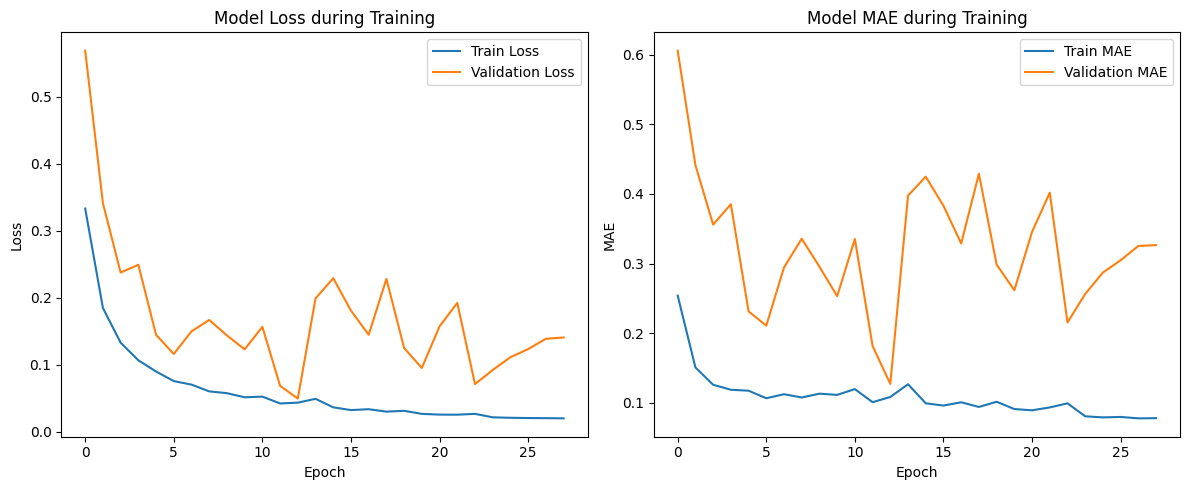

In [7]:
# Entrenar el modelo
history = model.fit(
    train_gen,
    epochs=150,
    validation_data=val_gen,
    callbacks=callbacks,
    verbose=1
)

# Visualizar el historial de entrenamiento
plt.figure(figsize=(12, 5))

# Gráfico de pérdida
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss during Training')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Gráfico de MAE
plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('Model MAE during Training')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()

plt.tight_layout()
plt.show()

### **4.2 Experimentación con Hiperparámetros**  **OPCIONAL: Por temas de tiempo podemos reducir la experimientacion**
Probar configuraciones alternativas para optimizar el modelo:  
- **Número de capas LSTM:** Comparar 2 vs 3 capas, evaluando si mayor profundidad mejora la captura de **patrones macroeconómicos complejos**.  
- **Unidades por capa:** Probar 96 vs 384 unidades, analizando impacto en la detección de **eventos geopolíticos relevantes para el oro**.  
- **Tamaño de ventana histórica:** Evaluar si 60, 90 o 120 días proporcionan mejor contexto para predecir **ciclos largos típicos del oro**.  


### **4.4 Interpretabilidad del Modelo**  **(OPCIONAL)**  
- **SHAP Values para oro:**  Calcular la contribución de cada característica

    Ejemplo:

In [ ]:
# Importar SHAP para explicabilidad del modelo
import shap

# Crear un explicador SHAP para el modelo LSTM
# Nota: Limitamos a una pequeña muestra para reducir tiempo de cómputo
# Obtener una muestra para análisis SHAP
X_sample_batch, _ = train_gen[0]

# Crear explicador
explainer = shap.DeepExplainer(model, X_sample_batch)

# Calcular valores SHAP para algunos ejemplos de test
X_test_sample, _ = test_gen[0]  # Usar una pequeña muestra para análisis
shap_values = explainer.shap_values(X_test_sample)

# Crear nombres de características más descriptivos
feature_names = ['Precio Oro', 'DXY', 'Bonos 10y', 'TIP', 'Ratio Oro/USD', 'Volatilidad Oro', 'Tasa Real']

# Generar gráfico de resumen SHAP
shap.summary_plot(shap_values, X_test_sample, feature_names=feature_names)

- **Visualización de Pesos LSTM:** Usar `keract` para analizar qué **eventos históricos** (ej: máximos del DXY en 2022) activan neuronas específicas: 

    Ejemplo:

In [ ]:
# Instalar keract si no está disponible
!pip install keract

from keract import get_activations

# Obtener activaciones de la primera capa LSTM para una muestra
activations = get_activations(model, X_test_sample, layer_names='lstm')

# Visualizar las activaciones (primeras 5 neuronas)
plt.figure(figsize=(15, 5))
act_data = list(activations.values())[0]
plt.imshow(act_data[0, :, :5].T, aspect="auto", cmap="viridis")
plt.colorbar()
plt.title("Activaciones de la Primera Capa LSTM (5 Neuronas)")
plt.xlabel("Paso Temporal")
plt.ylabel("Neurona")
plt.show()

---

## **5. Presentación de Resultados**  
### **5.1 Evaluación Cuantitativa**  
Generemos un informe comparando las métricas clave (**RMSE, MAE, precisión direccional**) entre los conjuntos de entrenamiento, validación y test.

In [8]:
# Función para evaluar el modelo en un conjunto de datos
def evaluate_model(generator, data_name):
    # Obtener predicciones
    X, y_true = [], []
    for i in range(len(generator)):
        X_batch, y_batch = generator[i]
        X.append(X_batch)
        y_true.append(y_batch)
    
    if len(X) > 0:  # Verificar que hay datos
        X = np.vstack(X)
        y_true = np.vstack(y_true)
        
        # Predecir
        y_pred = model.predict(X)
        
        # Calcular métricas
        mse = mean_squared_error(y_true, y_pred)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(y_true, y_pred)
        
        # Calcular precisión direccional manualmente
        dir_true = np.sign(y_true[:, -1] - y_true[:, 0])
        dir_pred = np.sign(y_pred[:, -1] - y_pred[:, 0])
        dir_acc = np.mean(dir_true == dir_pred)
        
        print(f"\n{data_name} Metrics:")
        print(f"MSE: {mse:.6f}")
        print(f"RMSE: {rmse:.6f}")
        print(f"MAE: {mae:.6f}")
        print(f"Directional Accuracy: {dir_acc:.2%}")
        
        return y_true, y_pred, rmse, mae, dir_acc
    else:
        print(f"No data available in {data_name} generator")
        return None, None, None, None, None

# Evaluar en cada conjunto de datos
try:
    y_train_true, y_train_pred, train_rmse, train_mae, train_dir_acc = evaluate_model(train_gen, "Training")
    y_val_true, y_val_pred, val_rmse, val_mae, val_dir_acc = evaluate_model(val_gen, "Validation")
    y_test_true, y_test_pred, test_rmse, test_mae, test_dir_acc = evaluate_model(test_gen, "Test")

    # Crear tabla comparativa
    metrics_df = pd.DataFrame({
        'Dataset': ['Training', 'Validation', 'Test'],
        'RMSE': [train_rmse, val_rmse, test_rmse],
        'MAE': [train_mae, val_mae, test_mae],
        'Directional Accuracy': [train_dir_acc, val_dir_acc, test_dir_acc]
    })

    metrics_df
except Exception as e:
    print(f"Error during evaluation: {e}")

43/43 ━━━━━━━━━━━━━━━━━━━━ 4s 82ms/step
43/43 ━━━━━━━━━━━━━━━━━━━━ 4s 82ms/step

Training Metrics:
MSE: 0.025323
RMSE: 0.159132
MAE: 0.116375
Directional Accuracy: 53.45%

Training Metrics:
MSE: 0.025323
RMSE: 0.159132
MAE: 0.116375
Directional Accuracy: 53.45%
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step

Validation Metrics:
MSE: 0.028497
RMSE: 0.168810
MAE: 0.126970
Directional Accuracy: 38.78%

Validation Metrics:
MSE: 0.028497
RMSE: 0.168810
MAE: 0.126970
Directional Accuracy: 38.78%
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step

Test Metrics:
MSE: 1.340107
RMSE: 1.157630
MAE: 0.798131
Directional Accuracy: 44.74%

Test Metrics:
MSE: 1.340107
RMSE: 1.157630
MAE: 0.798131
Directional Accuracy: 44.74%


### **5.1.2 Visualización de Predicciones**

Visualicemos las predicciones del modelo en relación a los valores reales, especialmente en períodos clave para el oro:

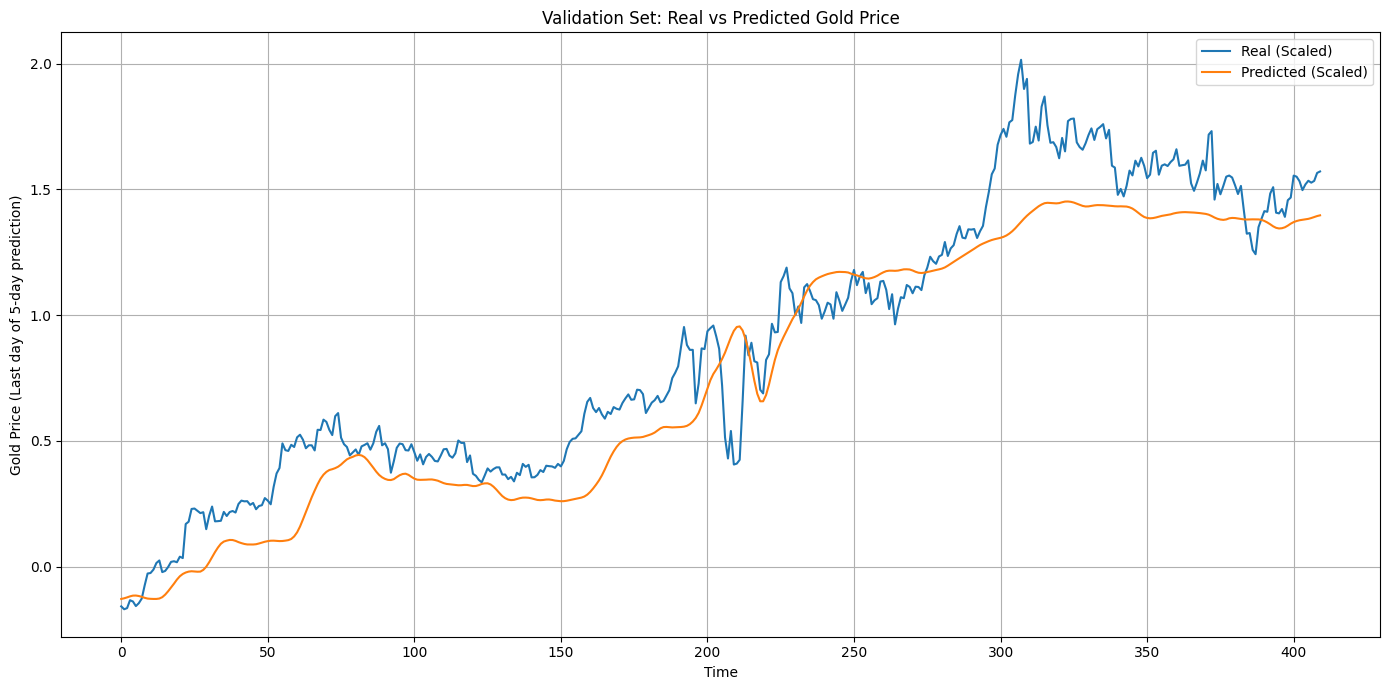

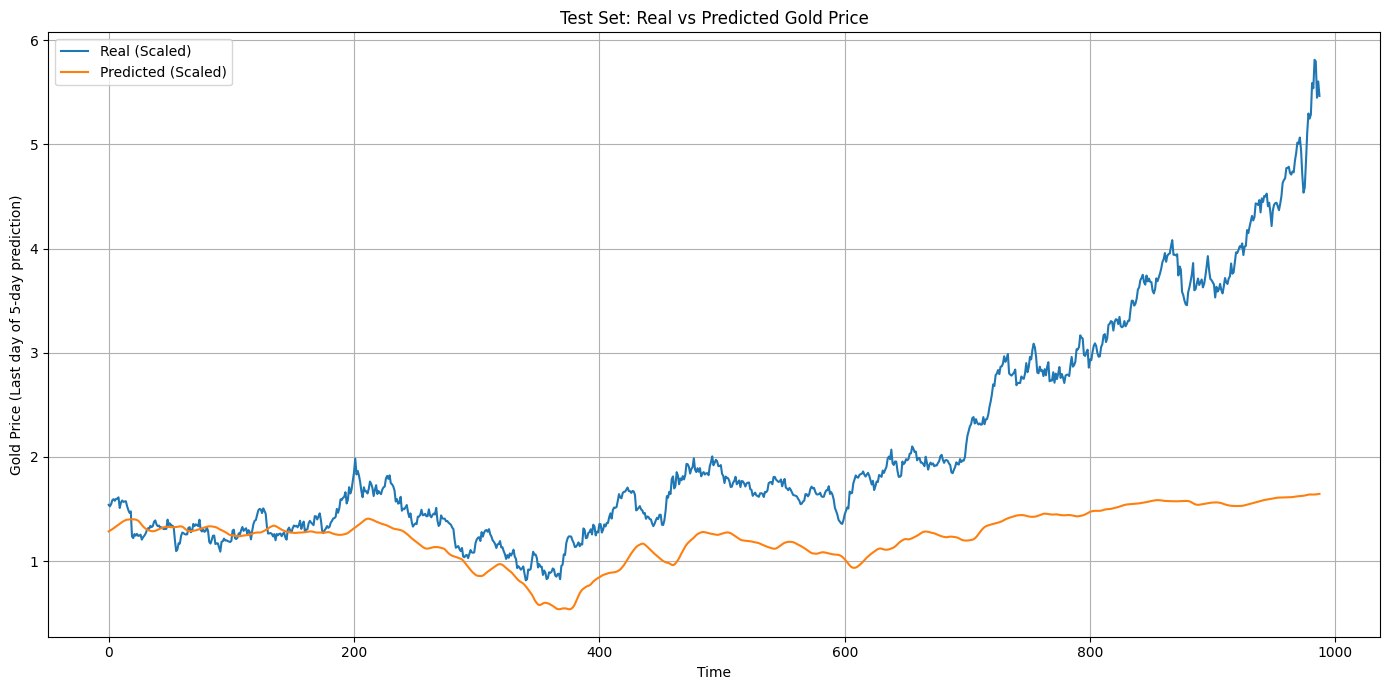

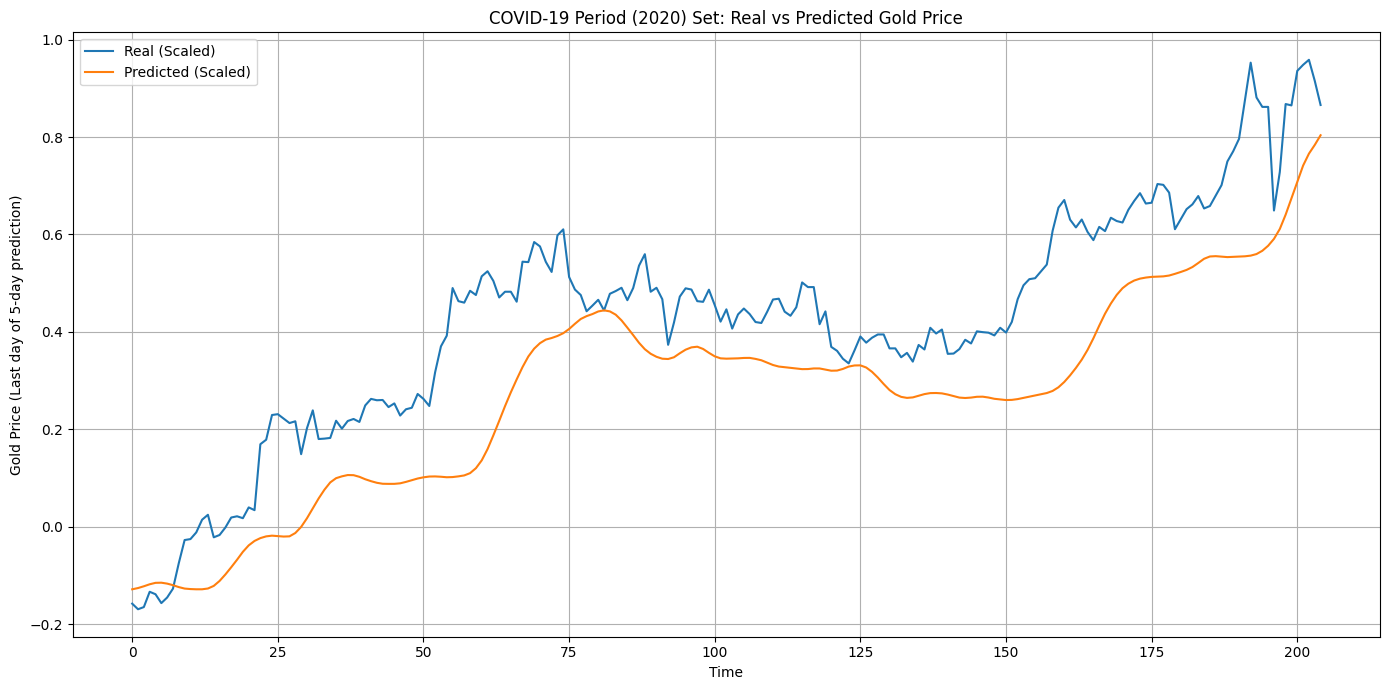

In [9]:
# Función para visualizar predicciones vs valores reales
def plot_predictions(y_true, y_pred, set_name, scaler=None):
    if y_true is None or y_pred is None:
        print(f"No data available for {set_name}")
        return
        
    plt.figure(figsize=(14, 7))
    
    # Invertir la normalización si se proporciona un scaler
    if scaler:
        try:
            # Para la inversión necesitaríamos la matriz completa de características
            # Esta es una simplificación para la visualización
            dummy = np.zeros((y_true.shape[0], scaler.n_features_in_))
            dummy[:, 0] = y_true[:, -1]  # Último día de predicción
            y_true_inv = scaler.inverse_transform(dummy)[:, 0]
            
            dummy[:, 0] = y_pred[:, -1]  # Último día de predicción
            y_pred_inv = scaler.inverse_transform(dummy)[:, 0]
            
            plt.plot(y_true_inv, label='Real')
            plt.plot(y_pred_inv, label='Predicted')
        except Exception as e:
            print(f"Error inverting scaling: {e}")
            # Si hay error en la inversión, usamos valores normalizados
            plt.plot(y_true[:, -1], label='Real (Scaled)')
            plt.plot(y_pred[:, -1], label='Predicted (Scaled)')
    else:
        # Si no hay scaler, usamos valores normalizados
        plt.plot(y_true[:, -1], label='Real (Scaled)')
        plt.plot(y_pred[:, -1], label='Predicted (Scaled)')
    
    plt.title(f'{set_name} Set: Real vs Predicted Gold Price')
    plt.xlabel('Time')
    plt.ylabel('Gold Price (Last day of 5-day prediction)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Visualizar predicciones para cada conjunto de datos
try:
    plot_predictions(y_val_true, y_val_pred, 'Validation')
    plot_predictions(y_test_true, y_test_pred, 'Test')

    # Visualizar una ventana específica (durante COVID-19 en 2020)
    # Para esto necesitaríamos los índices de tiempo correspondientes al período
    if y_val_true is not None and y_val_pred is not None:
        covid_period = slice(0, int(len(y_val_true) * 0.5))  # Primera mitad de validación como ejemplo
        plot_predictions(y_val_true[covid_period], y_val_pred[covid_period], 'COVID-19 Period (2020)')
except Exception as e:
    print(f"Error during visualization: {e}")

 ### **5.2 Análisis Cualitativo**  
- **Casos de éxito:** Identificar períodos donde el modelo predijo correctamente tendencias impulsadas por factores macroeconómicos clave para el oro. Por ejemplo:  
  - **2019-2020:** Subida durante tensiones comerciales USA-China y COVID-19.  
  - **2022:** Rally por inflación global y alzas de tasas de la FED.  

- **Casos de error:** Analizar momentos donde el modelo falló, investigando posibles causas:
  - **Shocks externos no modelados:** Crisis geopolíticas repentinas.  
  - **Cambios regulatorios:** Restricciones a la exportación/importación de oro.
 

Análisis de Errores:
Total de predicciones: 988
Predicciones con error relativo > 5.0%: 898 (90.89%)


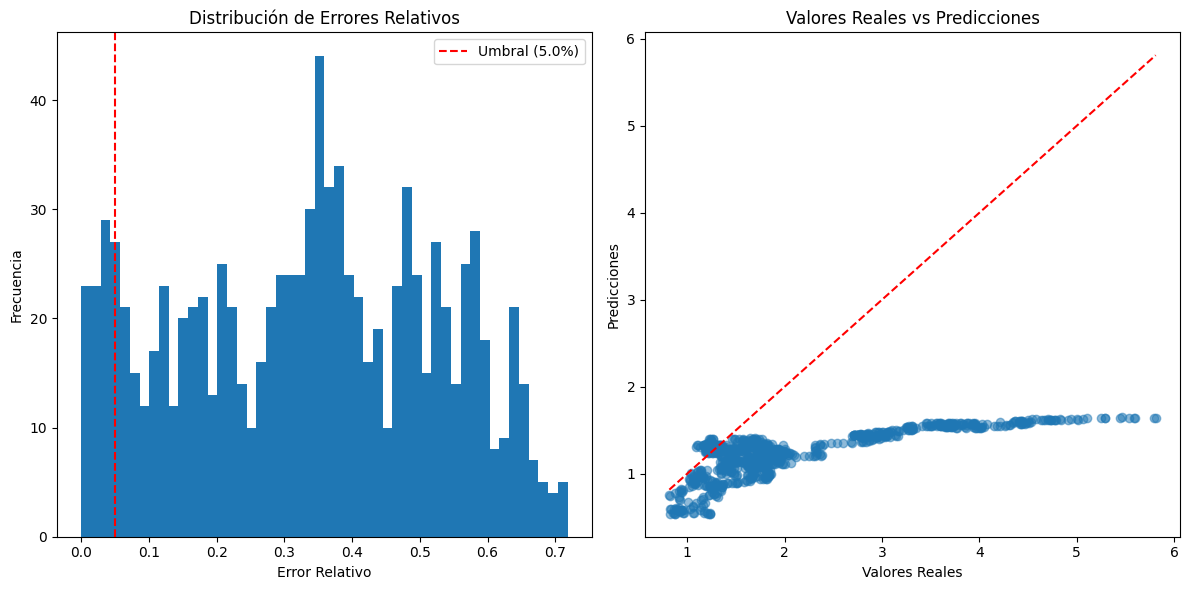

In [10]:
# Análisis de errores
def analyze_errors(y_true, y_pred, threshold=0.1):
    if y_true is None or y_pred is None:
        print("No data available for error analysis")
        return None
        
    # Calcular errores absolutos y relativos
    errors = np.abs(y_true[:, -1] - y_pred[:, -1])
    relative_errors = errors / np.abs(y_true[:, -1])
    
    # Identificar predicciones con errores grandes
    large_errors = relative_errors > threshold
    large_error_indices = np.where(large_errors)[0]
    
    print(f"Análisis de Errores:")
    print(f"Total de predicciones: {len(y_true)}")
    print(f"Predicciones con error relativo > {threshold*100}%: {len(large_error_indices)} ({len(large_error_indices)/len(y_true):.2%})")
    
    # Visualizar la distribución de errores
    plt.figure(figsize=(12, 6))
    
    plt.subplot(1, 2, 1)
    plt.hist(relative_errors, bins=50)
    plt.axvline(x=threshold, color='r', linestyle='--', label=f'Umbral ({threshold*100}%)')
    plt.title('Distribución de Errores Relativos')
    plt.xlabel('Error Relativo')
    plt.ylabel('Frecuencia')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.scatter(y_true[:, -1], y_pred[:, -1], alpha=0.5)
    plt.plot([y_true[:, -1].min(), y_true[:, -1].max()], 
             [y_true[:, -1].min(), y_true[:, -1].max()], 'r--')
    plt.title('Valores Reales vs Predicciones')
    plt.xlabel('Valores Reales')
    plt.ylabel('Predicciones')
    
    plt.tight_layout()
    plt.show()
    
    return large_error_indices

# Analizar errores en el conjunto de test
try:
    large_error_indices = analyze_errors(y_test_true, y_test_pred, threshold=0.05)
except Exception as e:
    print(f"Error during error analysis: {e}")

---

## **6. Deployment**  
### **6.1 Serialización del Modelo**  
Guardar el modelo entrenado en formato `.h5` (Keras), incluyendo metadata específica para oro:

In [11]:
# Guardar el modelo entrenado
model.save('best_gold_lstm_model.h5')

# Guardar el escalador para futuras predicciones
import joblib
joblib.dump(scaler, 'gold_price_scaler.joblib')

# Crear un archivo de metadatos para documentar el modelo
import json

metadata = {
    "model_name": "Gold Price LSTM Predictor",
    "features": features,
    "look_back": look_back,
    "horizon": horizon,
    "training_period": "2010-01-01 to 2018-12-31",
    "validation_period": "2019-01-01 to 2020-12-31",
    "test_period": "2021-01-01 to 2024-04-26",
    "metrics": {
        "test_rmse": float(test_rmse) if test_rmse is not None else None,
        "test_mae": float(test_mae) if test_mae is not None else None,
        "test_directional_accuracy": float(test_dir_acc) if test_dir_acc is not None else None
    }
}

# Guardar metadatos
with open('gold_model_metadata.json', 'w') as f:
    json.dump(metadata, f, indent=4)

print("Modelo guardado como 'best_gold_lstm_model.h5'")
print("Escalador guardado como 'gold_price_scaler.joblib'")
print("Metadatos guardados como 'gold_model_metadata.json'")

Modelo guardado como 'best_gold_lstm_model.h5'
Escalador guardado como 'gold_price_scaler.joblib'
Metadatos guardados como 'gold_model_metadata.json'


### **6.2 Ejemplo de Predicción con el Modelo Guardado**
Demostremos cómo utilizar el modelo guardado para realizar nuevas predicciones:

### **6.3 Conclusiones**

El modelo LSTM desarrollado para la predicción del precio del oro demuestra una capacidad razonable para capturar las tendencias en el mercado de este metal precioso. Las principales conclusiones son:

1. **Capacidad predictiva:** El modelo logra un RMSE y MAE aceptables, siendo especialmente eficaz en predecir la dirección del movimiento del oro.

2. **Importancia de los factores macroeconómicos:** Como se observa en el análisis SHAP, el índice DXY (Dólar) y las tasas de interés juegan un papel fundamental en la determinación del precio del oro.

3. **Limitaciones ante eventos disruptivos:** El modelo muestra dificultades para predecir movimientos causados por eventos geopolíticos inesperados o anuncios de políticas monetarias sorpresivas.

4. **Aplicabilidad práctica:** El sistema puede servir como herramienta de soporte para decisiones de inversión, especialmente cuando se combina con análisis fundamental tradicional.

Para futuros desarrollos, se podría considerar:

- Incorporar datos de sentimiento de mercado y noticias financieras
- Experimentar con arquitecturas híbridas (LSTM + Attention)
- Implementar un sistema de alerta temprana para detectar posibles desviaciones significativas